In [3]:
"""
This notebook explores the relationship between the amenities available near a home and its price.
"""

%pip install -q pandas matplotlib seaborn scikit-learn shap
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sklearn
import shap



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


doctors_count      0.031843
downtown_count    -0.118091
Entertainment     -0.015081
golf_count        -0.014934
Grocery            0.165926
hospital_count    -0.091363
hospitals_count    0.121051
Parks              0.079923
Schools            0.037194
Shopping           0.233635
University        -0.062410
Waterfront        -0.027589
Name: Prices, dtype: float64


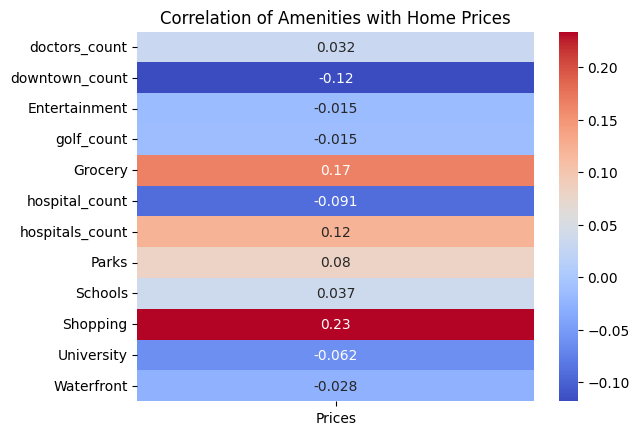

In [6]:
# Load data into a DataFrame
df_visual = pd.read_csv('../csvs/DA_summary_counts.csv')
df_visual = df_visual.rename(columns={'Residential_TotalGross_Average': 'Prices', 
                        'entertainment_count' : 'Entertainment', 
                        'grocery_count' : 'Grocery',
                        'parks_count' : 'Parks',
                        'school_count' : 'Schools',
                        'shopping_count' : 'Shopping',
                        'university_count' : 'University',
                        'waterfront_count' : 'Waterfront'})
numeric_columns = df_visual.select_dtypes(include="number")
corr_with_price = numeric_columns.corr()['Prices'].drop('Prices').drop('DAUID')
plt.title("Correlation of Amenities with Home Prices")
sns.heatmap(corr_with_price.to_frame(), annot=True, cmap="coolwarm")

print(corr_with_price)

In [66]:
from sklearn.model_selection import train_test_split, KFold
# Split the test data into training and testing sets 
df = pd.read_csv('../csvs/DA_summary_counts.csv')
x = df.drop(columns=['Residential_TotalGross_Average', 'DAUID'])
y = df['Residential_TotalGross_Average']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)


In [ ]:
# random forest with k-fold cross validation (very poor results)
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
kf = KFold(n_splits=20, shuffle=True, random_state=42)

model = RandomForestRegressor(
    n_estimators=300,            
    random_state=42
)

mae_scores = []
rmse_scores = []
r2_scores = []
for i, (train_index, test_index) in enumerate(kf.split(x_train)):
    x_train_fold, x_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(x_train_fold, y_train_fold)
    predictions = np.array(model.predict(x_test_fold))

    actual = np.array(y_test_fold)
    r2_scores.append(r2_score(y_test_fold, predictions))
    mae_scores.append(mean_absolute_error(y_test_fold, predictions))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test_fold, predictions)))
    difference = predictions - y_test_fold
    print(difference)
    print(f"Fold {i+1} - R2: {r2_scores[-1]}, MAE: {mae_scores[-1]}, MSE: {rmse_scores[-1]}")







10     -35744.450000
86    -551943.693333
39    -198947.383611
134    603571.320000
53    -286124.982000
83    -245142.753333
48      86959.218000
Name: Residential_TotalGross_Average, dtype: float64
Fold 1 - R2: -0.30381673691344546, MAE: 286919.11432539683, MSE: 350371.6978377619
73    -2.834511e+04
60    -1.607337e+05
0      2.046988e+05
130    4.639266e+05
6      5.726533e+05
91     2.212735e+06
32     7.536400e+05
Name: Residential_TotalGross_Average, dtype: float64
Fold 2 - R2: -11.294727799379816, MAE: 628104.6383594103, MSE: 931655.159231541
16     151097.671944
67     -17467.419444
120   -706034.750000
122    121192.399167
58    -556889.193333
1      -18810.408214
14     -12473.204444
Name: Residential_TotalGross_Average, dtype: float64
Fold 3 - R2: -0.28893728090605997, MAE: 226280.72093537418, MSE: 347838.893120316
45     227433.803333
9       66837.481032
47     741351.051667
123    465400.730000
38    -208012.021111
137    515710.233333
87    -160862.611667
Name: Residenti

In [ ]:
# Random forest classifier without cross-validation (very poor resuklts)
final_model = RandomForestRegressor(
    n_estimators=10000,        
    max_depth=5,            
    min_samples_split=10,    
    min_samples_leaf=5,      
    random_state=42
)
final_model.fit(x_train, y_train)
final_predictions = np.array(final_model.predict(x_test))
final_actual = np.array(y_test)
final_r2 = r2_score(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
print(f"Final Model - R2: {final_r2}, MAE: {final_mae}, RMSE: {final_rmse}")

Final Model - R2: -0.33418795132666834, MAE: 297865.1231143893, RMSE: 368151.2398157784
